In [116]:
import pandas as pd 
import numpy as np
from collections import  OrderedDict
from copy import deepcopy
from matplotlib import pyplot as plt
from matplotlib import rc
plt.rcParams.update({"text.usetex": True})
plt.rcParams['font.family']='sans-serif'

# LS + Btree

In [9]:
def gen_path(solver, solver_hyper, regularizer, depth_lst, 
            remove_ratio_lst = [0.05, 0.1, 0.2], 
            purpose='leastsquare_btree/details', 
            loss='ls', task='btree', lammax=1.0, lam_shrink=1e-2, 
            ):
    all_path = []
    for depth in depth_lst:
        dataset = f'ls_dep:{depth}_num:2x_sparse:0.1'
        for remove_ratio in remove_ratio_lst:
            path = f'../{purpose}/{solver}_{loss}_{regularizer}/{dataset}_lam_shrink:{lam_shrink}_{task}_{lammax}_{depth}_True_{remove_ratio}_{-1.0}'
            for k,v in solver_hyper.items():
                if k == 'ipg_strategy':
                    path += f'_{v}'
                else:
                    path += f'_{k}:{v}'
            path += '_stats.npy'
            all_path.append(path)
    return all_path

def create_hypers(solver, modify_dict={}):
    task_hypers_template = {
            'ProxGD':   OrderedDict({'proxgd_stepsize': 'linesearch'}),
            'ProxSAGA': OrderedDict({ 'ipg_strategy': 'linear_decay', 'seed':2023, 'proxsaga_lipcoef': 1.0,}),
            'ProxSVRG': OrderedDict({ 'ipg_strategy': 'linear_decay', 'seed':2023, 'proxsvrg_inner_repeat': 1, 'proxsvrg_lipcoef': 1.0}),
            'PStorm':   OrderedDict({ 'ipg_strategy': 'diminishing', 'seed':2023,'pstorm_stepsize': 'diminishing', 'pstorm_betak': -1.0, 'pstorm_lipcoef': 1.0}),
            'RDA':      OrderedDict({ 'ipg_strategy': 'diminishing', 'seed':2023, 'rda_stepconst': 1.0}),
            'SPStorm':  OrderedDict({ 'ipg_strategy': 'diminishing', 'seed':2023, 'spstorm_betak': -1.0, 'spstorm_zeta': 'dynanmic', 'spstorm_lipcoef': 1.0})
        }
    hypers = task_hypers_template[solver]
    for k,v in modify_dict.items():
        hypers[k] = v
    return hypers
def load_from_npy(all_path, selected_keys=['xend', 'nnz', 'nz', 'Fend', 'iteration', 'status'], verbose=False):
    instance_dict = {}
    total_failed = 0
    for path in all_path:
        try:
            info = np.load(path, allow_pickle=True).item()
            depth, remove_ratio = path.split('True')[0].split("_")[-2], path.split('True')[1].split("_")[1]
            instance_name = f'{depth}_{remove_ratio}'
            instance_dict[instance_name] = {k:info[k] for k in selected_keys}
            for k in ['total_bak_seq', 'inner_its_seq']:
                if k in selected_keys:
                    instance_dict[instance_name][k] = np.sum(info[k])
            if info['status'] not in [0,1]:
                if verbose:
                    print(f'Warning: {instance_name} is not solved, status: {info["status"]}')
                total_failed += 1
        except FileNotFoundError:
            info = None
    return instance_dict, total_failed

In [3]:
# get the ground truth
solver = 'ProxGD'
solver_hyper = create_hypers(solver)
all_path = gen_path(solver, solver_hyper, regularizer='TreeOG', depth_lst=[11,12,13])
ground_truth, total_failed = load_from_npy(all_path)

## Linear_decay VS diminishing

In [5]:
def get_alg_df(ground_truth, 
               solver = 'ProxSVRG',
               ipg_strategy_lst = ['linear_decay', 'diminishing'],
               lipcoef_lst = [0.1, 0.5, 1.0],
               list_of_metric = ['best_F_diff', 'last_nz_diff', 'first_id', 'first_cst_id', 'total_id'],
               max_epoch = 500):
    # collect raw results for solver
    dict_of_results = {}
    for ipg_strategy in ipg_strategy_lst:
        for lipcoef in lipcoef_lst:
            solver_hyper = create_hypers(solver)
            solver_hyper['ipg_strategy'] = ipg_strategy
            if solver != 'RDA':
                solver_hyper[f'{solver.lower()}_lipcoef'] = lipcoef
            else:
                solver_hyper[f'{solver.lower()}_stepconst'] = lipcoef
            solver_all_path = gen_path(solver, solver_hyper, regularizer='NatOG', depth_lst=[11,12,13])
            solver_result, total_failed = load_from_npy(solver_all_path, selected_keys=['time', 'total_bak_seq', 'inner_its_seq', 'Fbest', 'status', 'nz_seq'])
            print(ipg_strategy, lipcoef, '--- [exit without code 0 or 1]:', total_failed)
            print("="*50)
            dict_of_results[f'{ipg_strategy}_{lipcoef}'] = (solver_result, total_failed)

    # construct the df for ground truth    
    df_dict = {'instance':[], 'ProxGD_best_F':[], 'ProxGD_nz':[]}
    for k, v in ground_truth.items():
        df_dict['instance'].append(k)
        df_dict['ProxGD_best_F'].append(v['Fend'])
        df_dict['ProxGD_nz'].append(v['nz'])   
    
    # construct the df for solver
    for hyper_combine, solver_result in dict_of_results.items():
        for metric in list_of_metric:
            df_dict[f"{solver}_{hyper_combine}_{metric}"] = []
        for instance_name, instance_info in solver_result[0].items():
            nz_gt = ground_truth[instance_name]['nz']
            F_gt = ground_truth[instance_name]['Fend']
            nz_seq = instance_info['nz_seq']
            if solver == "ProxSVRG":
                # count as data pass
                nz_seq = nz_seq[:max_epoch+1]
            # handel identification metrics
            temp = np.where(np.array(nz_seq) == nz_gt)[0]
            total_identification = len(temp)
            if total_identification > 0:
                first_identification = temp[0]
                first_consistent_identification = np.nan
                for i in range(len(nz_seq)-1, -1, -1):
                    if np.array(nz_seq[i]) != nz_gt:
                        # the previous one is the first id
                        first_consistent_identification = i + 1
                        break
                if first_consistent_identification == 0 or first_consistent_identification == (max_epoch+1):
                    first_consistent_identification = np.nan
            else:
                first_identification = first_consistent_identification = total_identification = np.nan        
            df_dict[f"{solver}_{hyper_combine}_best_F_diff"].append(np.abs(instance_info['Fbest']-F_gt))
            df_dict[f"{solver}_{hyper_combine}_last_nz_diff"].append(np.abs(nz_seq[-1]-nz_gt))            
            df_dict[f"{solver}_{hyper_combine}_first_id"].append(first_identification)   
            df_dict[f"{solver}_{hyper_combine}_first_cst_id"].append(first_consistent_identification)
            df_dict[f"{solver}_{hyper_combine}_total_id"].append(total_identification)
        
    return pd.DataFrame.from_dict(df_dict)

### ProxSVRG

In [6]:
ipg_strategy_lst = ['linear_decay', 'diminishing']
lipcoef_lst = [0.1, 0.5, 1.0]
list_of_metric = ['best_F_diff', 'last_nz_diff', 'first_id', 'first_cst_id', 'total_id']
df = get_alg_df(ground_truth, 
               solver = 'ProxSVRG',
               ipg_strategy_lst = ipg_strategy_lst,
               lipcoef_lst = lipcoef_lst,
               list_of_metric = list_of_metric,
               max_epoch = 500)
# rank them by metrics
# 'bets_F_diff', 'last_nz_diff', 'first_id', 'first_cst_id', 'total_id'
score_list = []
for metric in list_of_metric:
    selected_cols = [col_name for col_name in df.columns if metric in col_name]
    df_metric = df[selected_cols].copy()
    score_mat_lst = []
    for lipcoef in lipcoef_lst:
        df_metric_subset = df_metric[[col_name for col_name in df_metric.columns if str(lipcoef) in col_name]]
        if metric != 'total_id':
            # smaller the number, higher rank, hence higher score,the better; break tie by min; penalize failed case
            df_rank = df_metric_subset.rank(axis=1, method='min', ascending=False).fillna(-1)
        else:
            # larger the number, higher rank, hence higher score,the better; break tie by min; penalize failed case
            df_rank = df_metric_subset.rank(axis=1, method='max', ascending=True).fillna(-1)
        
        score_mat_lst.append(df_rank.to_numpy())
        # print(df_metric_subset)
        # print(df_rank)
    score = np.sum(np.vstack(score_mat_lst), axis=0)
    score_list.append(score)
np.sum(np.vstack(score_list), axis=0)

linear_decay 0.1 --- [exit without code 0 or 1]: 6
linear_decay 0.5 --- [exit without code 0 or 1]: 3
linear_decay 1.0 --- [exit without code 0 or 1]: 3
diminishing 0.1 --- [exit without code 0 or 1]: 0
diminishing 0.5 --- [exit without code 0 or 1]: 0
diminishing 1.0 --- [exit without code 0 or 1]: 0


array([ 88., 194.])

### ProxSAGA

In [7]:
ipg_strategy_lst = ['linear_decay', 'diminishing']
lipcoef_lst = [0.1, 0.5, 1.0]
list_of_metric = ['best_F_diff', 'last_nz_diff', 'first_id', 'first_cst_id', 'total_id']
df = get_alg_df(ground_truth, 
               solver = 'ProxSAGA',
               ipg_strategy_lst = ipg_strategy_lst,
               lipcoef_lst = lipcoef_lst,
               list_of_metric = list_of_metric,
               max_epoch = 500)
# rank them by metrics
# 'bets_F_diff', 'last_nz_diff', 'first_id', 'first_cst_id', 'total_id'
score_list = []
for metric in list_of_metric:
    selected_cols = [col_name for col_name in df.columns if metric in col_name]
    df_metric = df[selected_cols].copy()
    score_mat_lst = []
    for lipcoef in lipcoef_lst:
        df_metric_subset = df_metric[[col_name for col_name in df_metric.columns if str(lipcoef) in col_name]]
        if metric != 'total_id':
            # smaller the number, higher rank, hence higher score,the better; break tie by min; penalize failed case
            df_rank = df_metric_subset.rank(axis=1, method='min', ascending=False).fillna(-1)
        else:
            # larger the number, higher rank, hence higher score,the better; break tie by min; penalize failed case
            df_rank = df_metric_subset.rank(axis=1, method='max', ascending=True).fillna(-1)
        
        score_mat_lst.append(df_rank.to_numpy())
        # print(df_metric_subset)
        # print(df_rank)
    score = np.sum(np.vstack(score_mat_lst), axis=0)
    score_list.append(score)
np.sum(np.vstack(score_list), axis=0)

linear_decay 0.1 --- [exit without code 0 or 1]: 9
linear_decay 0.5 --- [exit without code 0 or 1]: 6
linear_decay 1.0 --- [exit without code 0 or 1]: 3
diminishing 0.1 --- [exit without code 0 or 1]: 0
diminishing 0.5 --- [exit without code 0 or 1]: 0
diminishing 1.0 --- [exit without code 0 or 1]: 0


array([ 88., 208.])

## Tune stepsize (lipcoef, stepconst)

In [35]:
for solver in ['RDA', 'ProxSVRG', 'ProxSAGA', 'PStorm', 'SPStorm']:
    ipg_strategy_lst = ['diminishing']
    if solver == 'RDA':
        lipcoef_lst = [0.1, 1.0, 10.0]
    else:
        lipcoef_lst = [0.1, 0.5, 1.0]
    list_of_metric = ['best_F_diff', 'last_nz_diff', 'first_id', 'first_cst_id', 'total_id']
    df = get_alg_df(ground_truth, 
                   solver = solver,
                   ipg_strategy_lst = ipg_strategy_lst,
                   lipcoef_lst = lipcoef_lst,
                   list_of_metric = list_of_metric,
                   max_epoch = 500)
    # rank them by metrics
    # 'bets_F_diff', 'last_nz_diff', 'first_id', 'first_cst_id', 'total_id'
    score_list = []
    for metric in list_of_metric:
        selected_cols = [col_name for col_name in df.columns if metric in col_name]
        df_metric = df[selected_cols].copy()
        score_mat_lst = []
        if metric != 'total_id':
            # smaller the number, higher rank, hence higher score,the better; break tie by min; penalize failed case
            df_rank = df_metric.rank(axis=1, method='min', ascending=False).fillna(-1)
        else:
            # larger the number, higher rank, hence higher score,the better; break tie by min; penalize failed case
            df_rank = df_metric.rank(axis=1, method='max', ascending=True).fillna(-1)

        score_mat_lst.append(df_rank.to_numpy())
            # print(df_metric_subset)
            # print(df_rank)
        score = np.sum(np.vstack(score_mat_lst), axis=0)
        score_list.append(score)
    print(solver, np.sum(np.vstack(score_list), axis=0))

diminishing 0.1 --- [exit without code 0 or 1]: 9
diminishing 1.0 --- [exit without code 0 or 1]: 6
diminishing 10.0 --- [exit without code 0 or 1]: 2
RDA [-9. 19. 13.]
diminishing 0.1 --- [exit without code 0 or 1]: 0
diminishing 0.5 --- [exit without code 0 or 1]: 0
diminishing 1.0 --- [exit without code 0 or 1]: 0
ProxSVRG [ 33.  80. 107.]
diminishing 0.1 --- [exit without code 0 or 1]: 0
diminishing 0.5 --- [exit without code 0 or 1]: 0
diminishing 1.0 --- [exit without code 0 or 1]: 0
ProxSAGA [ 45.  84. 112.]
diminishing 0.1 --- [exit without code 0 or 1]: 0
diminishing 0.5 --- [exit without code 0 or 1]: 0
diminishing 1.0 --- [exit without code 0 or 1]: 0
PStorm [-9. -9. -9.]
diminishing 0.1 --- [exit without code 0 or 1]: 1
diminishing 0.5 --- [exit without code 0 or 1]: 1
diminishing 1.0 --- [exit without code 0 or 1]: 0
SPStorm [ 58.  84. 101.]


# Logit + chain

In [67]:
def gen_path(solver, solver_hyper, 
             chain_grpsize_lst=[10, 100], 
             chain_overlap_ratio_lst=[0.1, 0.2, 0.3], 
             lam_shrink_lst=[0.1, 0.01],
             datasets = ['a9a','w8a'],
             purpose='logit_chain/details', 
             loss='logit', task='chain',
            ):
    all_path = []
    for lam_shrink in lam_shrink_lst:
        for chain_grpsize in chain_grpsize_lst:
            for chain_overlap_ratio in chain_overlap_ratio_lst:
                for dataset in datasets:
                    path = f'../{purpose}/{solver}_{loss}_NatOG/{dataset}_lam_shrink:{lam_shrink}_{task}_{chain_grpsize}_{chain_overlap_ratio}_diminishing'
                    for k,v in solver_hyper.items():
                        if k == 'ipg_strategy':
                            path += f'_{v}'
                        else:
                            path += f'_{k}:{v}'
                    path += '_stats.npy'
                    all_path.append(path)
    return all_path
def create_hypers(solver, modify_dict={}):
    task_hypers_template = {
            'ProxSAGA': OrderedDict({  'seed':2023, 'proxsaga_lipcoef': 1.0,}),
            'ProxSVRG': OrderedDict({  'seed':2023, 'proxsvrg_inner_repeat': 1, 'proxsvrg_lipcoef': 1.0}),
            'PStorm':   OrderedDict({  'seed':2023,'pstorm_stepsize': 'diminishing', 'pstorm_betak': -1.0, 'pstorm_lipcoef': 1.0}),
            'RDA':      OrderedDict({  'seed':2023, 'rda_stepconst': 1.0}),
            'SPStorm':  OrderedDict({  'seed':2023, 'spstorm_betak': -1.0, 'spstorm_zeta': 'dynanmic', 'spstorm_lipcoef': 1.0})
        }
    hypers = task_hypers_template[solver]
    for k,v in modify_dict.items():
        hypers[k] = v
    return hypers

def load_from_npy(all_path, selected_keys, verbose=False):
    instance_dict = {}
    total_failed = 0
    for path in all_path:
        try:
            info = np.load(path, allow_pickle=True).item()
            instance_name = path.split('/')[-1].split('_seed')[0]
            instance_dict[instance_name] = {k:info[k] for k in selected_keys}
            for k in ['total_bak_seq', 'inner_its_seq']:
                if k in selected_keys:
                    instance_dict[instance_name][k] = np.sum(info[k])
            if info['status'] not in [0,1]:
                if verbose:
                    print(f'Warning: {instance_name} is not solved, status: {info["status"]}')
                total_failed += 1
        except FileNotFoundError:
            info = None
            print(f'Not found:{path}')
    return instance_dict, total_failed

def get_alg_df(nz_gt_dict, solver,
               lipcoef_lst = [0.1, 0.5, 1.0],
               chain_grpsize_lst=[10, 100], 
               chain_overlap_ratio_lst=[0.1, 0.2, 0.3], 
               lam_shrink_lst=[0.1, 0.01],
               datasets = ['a9a','w8a'],
               # list_of_metric = ['best_F', 'last_nz'],
               list_of_metric = ['best_F', 'last_nz_diff', 'first_id', 'first_cst_id', 'total_id'],
               max_epoch = 500):
    # collect raw results for solver
    dict_of_results = {}
    for lipcoef in lipcoef_lst:
        solver_hyper = create_hypers(solver)
        if solver != 'RDA':
            solver_hyper[f'{solver.lower()}_lipcoef'] = lipcoef
        else:
            solver_hyper[f'{solver.lower()}_stepconst'] = lipcoef
        solver_all_path = gen_path(solver, solver_hyper, chain_grpsize_lst, chain_overlap_ratio_lst, lam_shrink_lst, datasets)
        solver_result, total_failed = load_from_npy(solver_all_path, selected_keys=['time', 'Fbest', 'status', 'nz_seq'])
        print(lipcoef, '--- [exit without code 0 or 1]:', total_failed)
        print("="*50)
        dict_of_results[f'{lipcoef}'] = (solver_result, total_failed)

    # construct the df for ground truth    
    df_dict = {'instance':[]} 
    for k in ground_truth.keys():
        df_dict['instance'].append(k)
    # construct the df for solver
    for hyper_combine, solver_result in dict_of_results.items():
        for metric in list_of_metric:
            df_dict[f"{solver}_{hyper_combine}_{metric}"] = []
        for instance_name, instance_info in solver_result[0].items():
            nz_seq = instance_info['nz_seq']  
            nz_gt = nz_gt_dict[instance_name]
            if solver == "ProxSVRG":
                # count as data pass
                nz_seq = nz_seq[:max_epoch+1]
            # handel identification metrics
            temp = np.where(np.array(nz_seq) == nz_gt)[0]
            total_identification = len(temp)
            if total_identification > 0:
                first_identification = temp[0]
                first_consistent_identification = np.nan
                for i in range(len(nz_seq)-1, -1, -1):
                    if np.array(nz_seq[i]) != nz_gt:
                        # the previous one is the first id
                        first_consistent_identification = i + 1
                        break
                if first_consistent_identification == 0 or first_consistent_identification == (max_epoch+1):
                    first_consistent_identification = np.nan
            else:
                first_identification = first_consistent_identification = total_identification = np.nan                 
            df_dict[f"{solver}_{hyper_combine}_best_F"].append(np.abs(instance_info['Fbest']))
            # df_dict[f"{solver}_{hyper_combine}_last_nz"].append(np.abs(nz_seq[-1]))
            df_dict[f"{solver}_{hyper_combine}_last_nz_diff"].append(np.abs(nz_seq[-1]-nz_gt))            
            df_dict[f"{solver}_{hyper_combine}_first_id"].append(first_identification)   
            df_dict[f"{solver}_{hyper_combine}_first_cst_id"].append(first_consistent_identification)
            df_dict[f"{solver}_{hyper_combine}_total_id"].append(total_identification)            
    return pd.DataFrame.from_dict(df_dict)

In [68]:
# nz_gt_dict = {}
# for instance, nz in zip(df.instance, df['SPStorm_0.1_last_nz'].to_numpy()):
#     nz_gt_dict[instance] = nz
# nz_gt_dict
nz_gt_dict = {'a9a_lam_shrink:0.1_chain_10_0.1_diminishing': 12,
             'w8a_lam_shrink:0.1_chain_10_0.1_diminishing': 18,
             'a9a_lam_shrink:0.1_chain_10_0.2_diminishing': 11,
             'w8a_lam_shrink:0.1_chain_10_0.2_diminishing': 23,
             'a9a_lam_shrink:0.1_chain_10_0.3_diminishing': 16,
             'w8a_lam_shrink:0.1_chain_10_0.3_diminishing': 21,
             'a9a_lam_shrink:0.1_chain_100_0.1_diminishing': 1,
             'w8a_lam_shrink:0.1_chain_100_0.1_diminishing': 0,
             'a9a_lam_shrink:0.1_chain_100_0.2_diminishing': 1,
             'w8a_lam_shrink:0.1_chain_100_0.2_diminishing': 0,
             'a9a_lam_shrink:0.1_chain_100_0.3_diminishing': 0,
             'w8a_lam_shrink:0.1_chain_100_0.3_diminishing': 0,
             'a9a_lam_shrink:0.01_chain_10_0.1_diminishing': 7,
             'w8a_lam_shrink:0.01_chain_10_0.1_diminishing': 3,
             'a9a_lam_shrink:0.01_chain_10_0.2_diminishing': 8,
             'w8a_lam_shrink:0.01_chain_10_0.2_diminishing': 4,
             'a9a_lam_shrink:0.01_chain_10_0.3_diminishing': 8,
             'w8a_lam_shrink:0.01_chain_10_0.3_diminishing': 6,
             'a9a_lam_shrink:0.01_chain_100_0.1_diminishing': 1,
             'w8a_lam_shrink:0.01_chain_100_0.1_diminishing': 0,
             'a9a_lam_shrink:0.01_chain_100_0.2_diminishing': 1,
             'w8a_lam_shrink:0.01_chain_100_0.2_diminishing': 0,
             'a9a_lam_shrink:0.01_chain_100_0.3_diminishing': 0,
             'w8a_lam_shrink:0.01_chain_100_0.3_diminishing': 0}

In [120]:
# solver = 'ProxSVRG'
# solver_hyper = create_hypers(solver)
# all_path = gen_path(solver, solver_hyper, datasets = ['a9a','w8a'])
# solver_result, total_failed = load_from_npy(all_path,  selected_keys=['time', 'total_bak_seq', 'inner_its_seq', 'Fbest', 'status', 'nz_seq'])
df = get_alg_df(nz_gt_dict, solver = 'ProxSVRG',lipcoef_lst = [0.1, 0.5, 1.0])

0.1 --- [exit without code 0 or 1]: 0
0.5 --- [exit without code 0 or 1]: 0
1.0 --- [exit without code 0 or 1]: 0


In [121]:
solver = 'ProxSVRG'
metric = 'total_id'
cols = []
for const in [0.1, 0.5, 1.0]:
    cols += [f'{solver}_{const}_{metric}']
df_ = df[cols]
all_failed_index = df_.isin([np.nan]).all(1)
all_failed_count = np.sum(all_failed_index)
print(f"All failed in {all_failed_count} / {df_.shape[0]} cases")
df_valid = df[~all_failed_index][['instance']+cols]
# higher score; the better; break tie by max
df_score= df_valid.rank(axis=1, method='max', ascending=True, numeric_only=True)
df_score['correction'] = df_valid.isnull().sum(axis=1)
for const in [0.1, 0.5, 1.0]:
    df_score[f'{solver}_{const}_{metric}'] += df_score['correction']
df_score = df_score.fillna(0)[cols]
total_id_score = df_score.sum(axis=0).to_numpy()


metric = 'first_id'
cols = []
for const in [0.1, 0.5, 1.0]:
    cols += [f'{solver}_{const}_{metric}']
df_ = df[cols]
all_failed_index = df_.isin([np.nan]).all(1)
all_failed_count = np.sum(all_failed_index)
df_valid = df[~all_failed_index][['instance']+cols]
# higher score; the better; break tie by max
df_score= df_valid.rank(axis=1, method='max', ascending=False, numeric_only=True)
df_score['correction'] = df_valid.isnull().sum(axis=1)
for const in [0.1, 0.5, 1.0]:
    df_score[f'{solver}_{const}_{metric}'] += df_score['correction']
df_score = df_score.fillna(0)[cols]
first_id_score = df_score.sum(axis=0).to_numpy()

metric = 'first_cst_id'
cols = []
for const in [0.1, 0.5, 1.0]:
    cols += [f'{solver}_{const}_{metric}']
df_ = df[cols]
all_failed_index = df_.isin([np.nan]).all(1)
all_failed_count = np.sum(all_failed_index)
df_valid = df[~all_failed_index][['instance']+cols]
# higher score; the better; break tie by max
df_score= df_valid.rank(axis=1, method='max', ascending=False, numeric_only=True)
df_score['correction'] = df_valid.isnull().sum(axis=1)
for const in [0.1, 0.5, 1.0]:
    df_score[f'{solver}_{const}_{metric}'] += df_score['correction']
df_score = df_score.fillna(0)[cols]
first_cst_id_score = df_score.sum(axis=0).to_numpy()

metric = 'best_F'
cols = []
for const in [0.1, 0.5, 1.0]:
    cols += [f'{solver}_{const}_{metric}']
df_ = df[cols]
all_failed_index = df_.isin([np.nan]).all(1)
all_failed_count = np.sum(all_failed_index)
df_valid = df[~all_failed_index][['instance']+cols]
# higher score; the better; break tie by max
df_score= df_valid.rank(axis=1, method='max', ascending=False, numeric_only=True)
df_score['correction'] = df_valid.isnull().sum(axis=1)
for const in [0.1, 0.5, 1.0]:
    df_score[f'{solver}_{const}_{metric}'] += df_score['correction']
df_score = df_score.fillna(0)[cols]
Fval_score = df_score.sum(axis=0).to_numpy()


index = ['total identification', 'first identification', 'first consistent identification', 'Fval']
plot_df_dict = {}
lipcoef_lst = [0.1, 0.5, 1.0]
for i in range(len(lipcoef_lst)):
    plot_df_dict[lipcoef_lst[i]] = [total_id_score[i], first_id_score[i], first_cst_id_score[i], Fval_score[i]]
plot_df = pd.DataFrame.from_dict(plot_df_dict)
plot_df.index = index
plot_df_row_sum = plot_df.sum(1)
for i in range(len(plot_df_row_sum)):
    for col in lipcoef_lst:
        plot_df[col][i] /= plot_df_row_sum[i]
        
plot_df

All failed in 0 / 24 cases


,0.1,0.5,1.0
total identification,0.242775,0.346821,0.410405
first identification,0.242775,0.346821,0.410405
first consistent identification,0.242775,0.346821,0.410405
Fval,0.268156,0.368715,0.363128


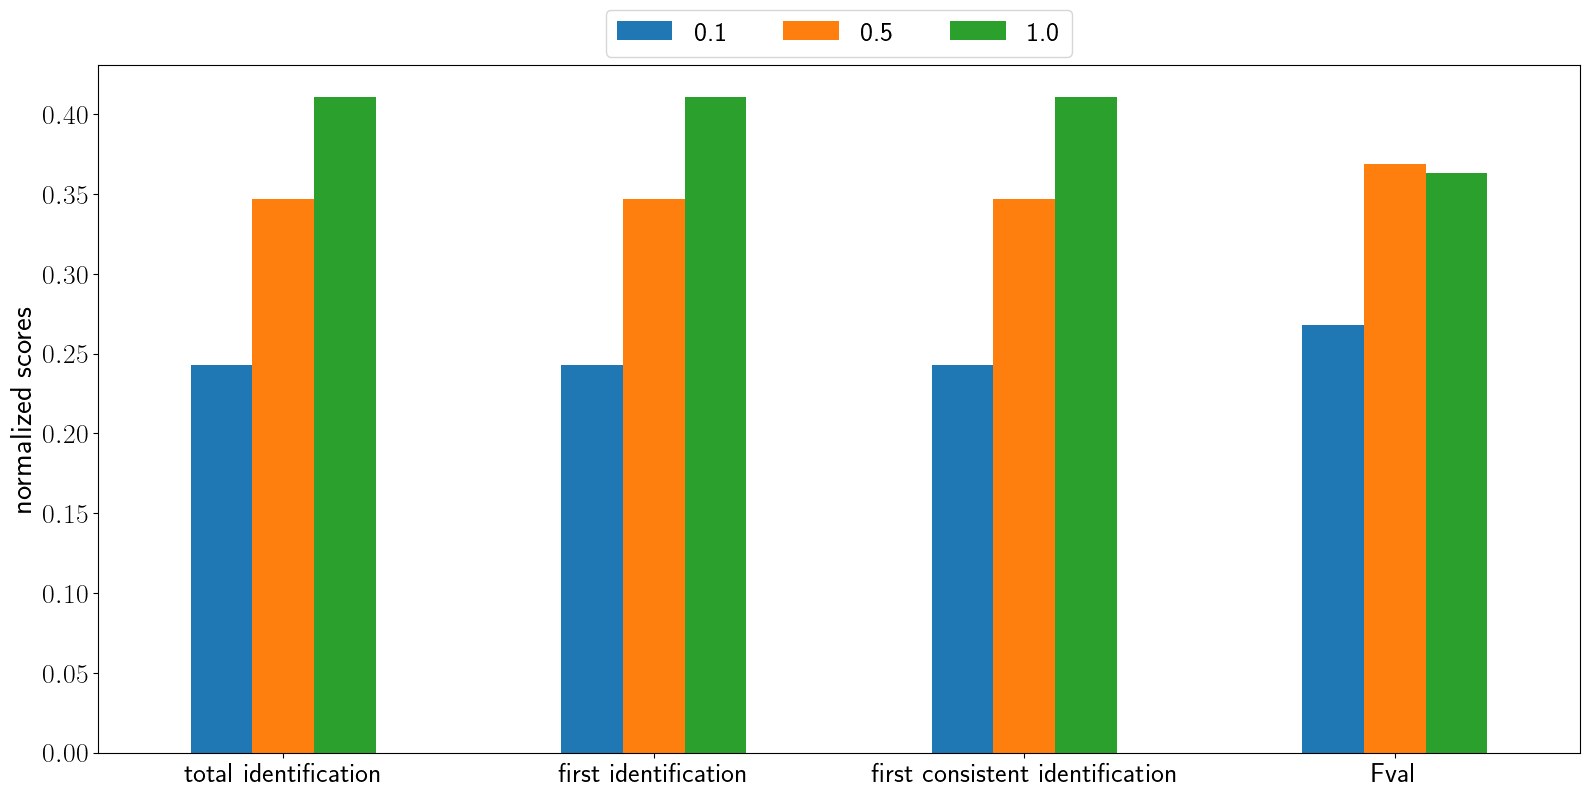

In [117]:
legend_label=lipcoef_lst
ax = plot_df.plot.bar(rot=0, figsize=(16, 8), fontsize=20)
L=ax.legend(legend_label, loc='upper center', bbox_to_anchor=(0.5, 1.1), ncol=len(lipcoef_lst), fancybox=True, prop={'size': 20, 'family':'monospace'})
plt.ylabel('normalized scores', fontdict={'size': 22})
plt.tight_layout(w_pad=0)

In [122]:
df = get_alg_df(nz_gt_dict, solver = 'RDA',lipcoef_lst = [0.01, 0.1, 1.0, 10.0])

0.01 --- [exit without code 0 or 1]: 0
0.1 --- [exit without code 0 or 1]: 0
1.0 --- [exit without code 0 or 1]: 0
10.0 --- [exit without code 0 or 1]: 0


In [123]:
solver = 'RDA'
metric = 'total_id'
cols = []
lipcoef_lst = [0.01, 0.1, 1.0, 10.0]
for const in lipcoef_lst:
    cols += [f'{solver}_{const}_{metric}']
df_ = df[cols]
all_failed_index = df_.isin([np.nan]).all(1)
all_failed_count = np.sum(all_failed_index)
print(f"All failed in {all_failed_count} / {df_.shape[0]} cases")
df_valid = df[~all_failed_index][['instance']+cols]
# higher score; the better; break tie by max
df_score= df_valid.rank(axis=1, method='max', ascending=True, numeric_only=True)
df_score['correction'] = df_valid.isnull().sum(axis=1)
for const in lipcoef_lst:
    df_score[f'{solver}_{const}_{metric}'] += df_score['correction']
df_score = df_score.fillna(0)[cols]
total_id_score = df_score.sum(axis=0).to_numpy()


metric = 'first_id'
cols = []
for const in lipcoef_lst:
    cols += [f'{solver}_{const}_{metric}']
df_ = df[cols]
all_failed_index = df_.isin([np.nan]).all(1)
all_failed_count = np.sum(all_failed_index)
df_valid = df[~all_failed_index][['instance']+cols]
# higher score; the better; break tie by max
df_score= df_valid.rank(axis=1, method='max', ascending=False, numeric_only=True)
df_score['correction'] = df_valid.isnull().sum(axis=1)
for const in lipcoef_lst:
    df_score[f'{solver}_{const}_{metric}'] += df_score['correction']
df_score = df_score.fillna(0)[cols]
first_id_score = df_score.sum(axis=0).to_numpy()

metric = 'first_cst_id'
cols = []
for const in lipcoef_lst:
    cols += [f'{solver}_{const}_{metric}']
df_ = df[cols]
all_failed_index = df_.isin([np.nan]).all(1)
all_failed_count = np.sum(all_failed_index)
df_valid = df[~all_failed_index][['instance']+cols]
# higher score; the better; break tie by max
df_score= df_valid.rank(axis=1, method='max', ascending=False, numeric_only=True)
df_score['correction'] = df_valid.isnull().sum(axis=1)
for const in lipcoef_lst:
    df_score[f'{solver}_{const}_{metric}'] += df_score['correction']
df_score = df_score.fillna(0)[cols]
first_cst_id_score = df_score.sum(axis=0).to_numpy()

metric = 'best_F'
cols = []
for const in lipcoef_lst:
    cols += [f'{solver}_{const}_{metric}']
df_ = df[cols]
all_failed_index = df_.isin([np.nan]).all(1)
all_failed_count = np.sum(all_failed_index)
df_valid = df[~all_failed_index][['instance']+cols]
# higher score; the better; break tie by max
df_score= df_valid.rank(axis=1, method='max', ascending=False, numeric_only=True)
df_score['correction'] = df_valid.isnull().sum(axis=1)
for const in lipcoef_lst:
    df_score[f'{solver}_{const}_{metric}'] += df_score['correction']
df_score = df_score.fillna(0)[cols]
Fval_score = df_score.sum(axis=0).to_numpy()


index = ['total identification', 'first identification', 'first consistent identification', 'Fval']
plot_df_dict = {}
lipcoef_lst = lipcoef_lst
for i in range(len(lipcoef_lst)):
    plot_df_dict[lipcoef_lst[i]] = [total_id_score[i], first_id_score[i], first_cst_id_score[i], Fval_score[i]]
plot_df = pd.DataFrame.from_dict(plot_df_dict)
plot_df.index = index
plot_df_row_sum = plot_df.sum(1)
for i in range(len(plot_df_row_sum)):
    for col in lipcoef_lst:
        plot_df[col][i] /= plot_df_row_sum[i]
        
plot_df

All failed in 2 / 24 cases


,0.01,0.10,1.00,10.00
total identification,0.396396,0.261261,0.18018,0.162162
first identification,0.396396,0.261261,0.18018,0.162162
first consistent identification,0.396396,0.261261,0.18018,0.162162
Fval,0.400000,0.300000,0.20000,0.100000


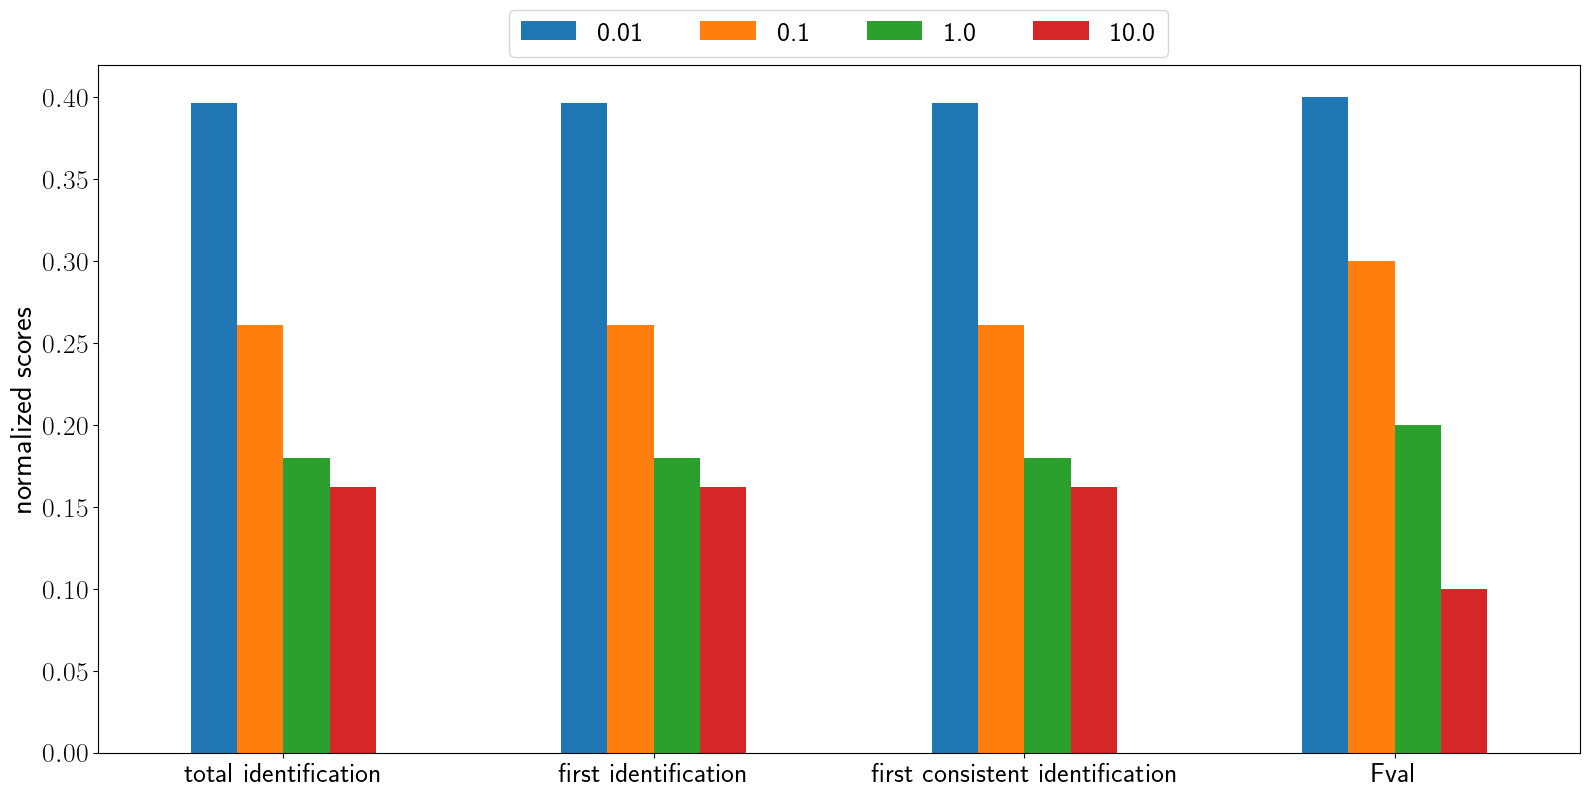

In [124]:
legend_label=lipcoef_lst
ax = plot_df.plot.bar(rot=0, figsize=(16, 8), fontsize=20)
L=ax.legend(legend_label, loc='upper center', bbox_to_anchor=(0.5, 1.1), ncol=len(lipcoef_lst), fancybox=True, prop={'size': 20, 'family':'monospace'})
plt.ylabel('normalized scores', fontdict={'size': 22})
plt.tight_layout(w_pad=0)

In [28]:
# df = get_alg_df(ground_truth, 
#                solver = 'RDA',
#                ipg_strategy_lst = ipg_strategy_lst,
#                lipcoef_lst = [0.1, 0.5, 1.0, 10, 100],
#                list_of_metric = list_of_metric,
#                max_epoch = 500)
# df[['instance',	'ProxGD_best_F', 'ProxGD_nz'] + [col for col in df.columns if str(0.5) in col]]

In [40]:
# solver = 'RDA'
# dict_of_results = {}
# for lipcoef in [0.1, 0.5, 1.0, 10.0, 100.0]:
#     solver_hyper = create_hypers(solver)
#     solver_hyper['ipg_strategy'] = 'diminishing'
#     if solver != 'RDA':
#         solver_hyper[f'{solver.lower()}_lipcoef'] = lipcoef
#     else:
#         solver_hyper[f'{solver.lower()}_stepconst'] = lipcoef
#     solver_all_path = gen_path(solver, solver_hyper, regularizer='NatOG', depth_lst=[11,12,13])
#     solver_result, total_failed = load_from_npy(solver_all_path, selected_keys=['time', 'total_bak_seq', 'inner_its_seq', 'Fbest', 'status', 'nz_seq'])
#     print('diminishing', lipcoef, '--- [exit without code 0 or 1]:', total_failed)
#     print("="*50)
#     dict_of_results[f'diminishing_{lipcoef}'] = (solver_result, total_failed)

In [30]:
# for c in [0.1, 0.5, 1.0, 10.0, 100.0]:
#     infos = dict_of_results[f'diminishing_{c}'][0]
#     print(f"================================ {c} =================================")
#     for instance in infos.keys():
#         print(f"status: {infos[instance]['status']:+d}, inner_its: {infos[instance]['inner_its_seq']:8d}, total_bak_seq: {infos[instance]['total_bak_seq']:8d}")


In [ ]:
# solver = 'ProxSVRG'
# dict_of_results = {}
# for ipg_strategy in ['linear_decay', 'diminishing']:
#     for lipcoef in [0.1, 0.5, 1.0]:
#         solver_hyper = create_hypers(solver)
#         solver_hyper['ipg_strategy'] = ipg_strategy
#         solver_hyper[f'{solver.lower()}_lipcoef'] = lipcoef
#         solver_all_path = gen_path(solver, solver_hyper, regularizer='NatOG', depth_lst=[11,12,13])
#         solver_result, total_failed = load_from_npy(solver_all_path, selected_keys=['time', 'total_bak_seq', 'inner_its_seq', 'Fbest', 'status', 'nz_seq'])
#         print(ipg_strategy, lipcoef, '--- [exit without code 0 or 1]:', total_failed)
#         print("="*50)
#         dict_of_results[f'{ipg_strategy}_{lipcoef}'] = (solver_result, total_failed)

# code for check why exits without code 0 ,1       
# solver_hyper = create_hypers(solver)
# solver_hyper['ipg_strategy'] = 'linear_decay'
# solver_hyper[f'{solver.lower()}_lipcoef'] = 0.1
# solver_all_path = gen_path(solver, solver_hyper, regularizer='NatOG', depth_lst=[11,12,13])
# solver_result, total_failed = load_from_npy(solver_all_path, selected_keys=['time', 'total_bak_seq', 'inner_its_seq', 'Fbest', 'status'], verbose=True)
# for i in range(len(solver_all_path)):
#     info = np.load(solver_all_path[i], allow_pickle=True).item()
#     print(np.sum(info['total_bak_seq']),np.sum(info['inner_its_seq']))


# # objective value
# selected_cols = [col_name for col_name in df.columns if 'best_F' in col_name]
# df_F = df[selected_cols].copy()
# for col in selected_cols[1:]:
#     df_F[col] = np.abs(df_F[col] - df_F[selected_cols[0]])

# score_mat_lst = []
# for lipcoef in lipcoef_lst:
#     df_F_subset = df_F[[col_name for col_name in df_F.columns if str(lipcoef) in col_name]]
#     # smaller difference, higher rank, hence higher score,the better; break tie by min
#     score_mat_lst.append(df_F_subset.rank(axis=1, method='min', ascending=False).to_numpy())
# F_score = np.sum(np.vstack(score_mat_lst)-1.0, axis=0)